## Production-Ready Agent Engineering: From MCP to RL

### Lecture 4: Introduction to Reinforcement Learning

**Instructor: Will Brown**

*Date: June 26, 2025*

#### GRPO from Scratch (Kinda)
- What's the goal of RL?
- Guessing a Hidden Number
- Rollouts, Groups, and Batches
- Advantage Estimation
- Policy Gradient + KL Penalties

### What's the Goal of RL?

- Environment = Markov Decision Process (MDP)
- MDP = States, Actions, Probabilities (Dynamics), Rewards, ... 
- Goal: find *policy* which maximizes reward over a given *horizon* 
- Horizon: finite (T steps), infinite discounted (recency bias), infinite un-discounted (requires "mixing" guarantee)
- Policy: Mapping from state to action (possibly randomized, possibly step-dependent)


```python
# MDP + policy
import random

S = {1,2,3,4,5} # states 
A = {'a', 'b', 'c'} 

def R(s,a) -> float:
    # returns reward score (e.g. in [0,1])
    ...

def P(s: S, a: A) -> list[float]:
    # returns list p where:
    # p[i] >= 0
    # sum(p) == 1
    # len(p) == len(S)
    ... 

env = (S, A, P, R)

def pi(s: S) -> A 
    # returns action for given state

# rollout / trajectory
T = 100
s_t = 1
r_T = 0
for t in range(T):
    a_t = pi(s_t)
    r_t = R(s_t, a_t)
    r_T += r_t
    s_t = random.choices(S, weights=P(s_t, a_t))

# r_T = total reward
```

#### Reinforcement Learning (Policy Optimization)
- Often "Explore, then Exploit"
- Initial policies try many different things
- Optimizers learn which actions correspond to higher rewards (value iteration, Q-learning, policy gradient, etc)
- Over time, place more "weight" on strategies which have been identified as "high reward"

#### For LLMs:
- `s_t` = context so far
- `a_t` = next token
- `pi(s_t)` = model's next-token distribution
- `r_T` = total rewards/evals for rollout


### GRPO Warm-Up: Guess the Hidden Number
- Single-turn game
- 

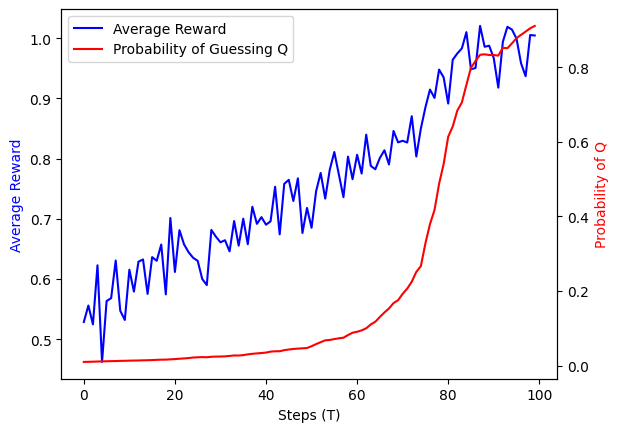

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import numpy as np 

Q = 4
N = 100
A = list(range(N))
T = 100

bs = 1000 # batch size
lr = 0.005 # learning rate
 
def R(a, Q=Q):
    Q_delta = abs(a - Q) / N
    noise = np.random.normal(0, 1)
    return 1 + noise - Q_delta

pi_t = np.ones(len(A)) / len(A) # uniform policy

rewards = []
q_probs = []
for t in range(T):
    # sample batch of actions
    actions = np.random.choice(A, size=bs, p=pi_t)
    # estimate advantage for all actions
    actions_rewards = [(a, R(a)) for a in actions]
    r_avg = np.mean([r for a, r in actions_rewards])
    r_std = np.std([r for a, r in actions_rewards])

    for a, r in actions_rewards:
        advantage = r - r_avg
        pi_t[a] = pi_t[a] * (1 + lr * advantage / r_std)

    # renormalize
    pi_t = pi_t / np.sum(pi_t)

    # store
    rewards.append(r_avg)
    q_probs.append(pi_t[Q])


fig, ax1 = plt.subplots()

ax1.set_xlabel("Steps (T)")
ax1.plot(rewards, color="blue", label="Average Reward")
ax1.set_ylabel("Average Reward", color="blue")
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax2.plot(q_probs, color="red", label="Probability of Guessing Q")
ax2.set_ylabel("Probability of Q", color="red")
ax2.tick_params(axis='y')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.show()

### GRPO for LLMs

- Very similar idea
- Policy = neural net (LLM) instead of list
- State = full history of tokens (including prompts, formatting, tool call results, etc)
- Multiple prompts per batch, multiple rollouts per prompt ("Group" = the G in GRPO)


In [63]:
from verifiers.utils.data_utils import load_example_dataset, extract_boxed_answer

dataset = load_example_dataset("math")

B = 4
prompts = dataset.select(range(B))

G = 8
# duplicate the prompts G times
batch_prompts = prompts.repeat(G)

batch_prompts[:10]

{'question': ['Let \\[f(x) = \\left\\{\n\\begin{array}{cl} ax+3, &\\text{ if }x>2, \\\\\nx-5 &\\text{ if } -2 \\le x \\le 2, \\\\\n2x-b &\\text{ if } x <-2.\n\\end{array}\n\\right.\\]Find $a+b$ if the piecewise function is continuous (which means that its graph can be drawn without lifting your pencil from the paper).',
  'A rectangular band formation is a formation with $m$ band members in each of $r$ rows, where $m$ and $r$ are integers. A particular band has less than 100 band members. The director arranges them in a rectangular formation and finds that he has two members left over. If he increases the number of members in each row by 1 and reduces the number of rows by 2, there are exactly enough places in the new formation for each band member. What is the largest number of members the band could have?',
  'What is the degree of the polynomial $(4 +5x^3 +100 +2\\pi x^4 + \\sqrt{10}x^4 +9)$?',
  'Evaluate $\\left\\lceil3\\left(6-\\frac12\\right)\\right\\rceil$.',
  'Let \\[f(x) = \

In [64]:
from openai import OpenAI
import verifiers as vf
parser = vf.ThinkParser(extract_fn=extract_boxed_answer)

system_prompt = """
Think step-by-step inside <think>...</think> tags.

Then, give your final numerical answer inside \\boxed{{...}}.
"""

def correct_answer_reward_func(completion, answer, **kwargs):
    response = parser.parse_answer(completion) or ''
    return 1.0 if response == answer else 0.0

vf_env = vf.SingleTurnEnv(
    dataset=batch_prompts,
    system_prompt=system_prompt,
    parser=parser,
    rubric=vf.Rubric(funcs=[correct_answer_reward_func], weights=[1.0]),
)

client = OpenAI()
model = "gpt-4.1-nano"
batch_results = vf_env.evaluate(client, model)

Map (num_proc=32):   0%|          | 0/32 [00:00<?, ? examples/s]

2025-06-25 20:37:14 - verifiers.envs.SingleTurnEnv - INFO - eval_dataset is not set, falling back to train dataset
Evaluating 32 rollouts: 100%|██████████| 32/32 [00:00<00:00, 5327.16it/s]


In [67]:
len(batch_results['reward'])


32

In [70]:
for i in range(B):
    prompt_ans = []
    prompt_rewards = []
    for j in range(G):
        rollout_ij_idx = j*B + i
        reward_ij = batch_results['reward'][rollout_ij_idx]
        prompt_rewards.append(reward_ij)
        ans_ij = parser.parse_answer(batch_results['completion'][rollout_ij_idx][-1]['content'])
        prompt_ans.append(ans_ij)
    prompt_r_avg = float(np.mean(prompt_rewards))
    prompt_r_std = float(np.std(prompt_rewards) + 0.0001)
    advantages = [f"{float(r - prompt_r_avg / prompt_r_std):.3f}" for r in prompt_rewards]
    q = batch_results['question'][i]
    a = batch_results['answer'][i]
    print("q: ", q)
    print("a: ", a)
    print("prompt_ans: ", prompt_ans)
    print("advantages: ", advantages)
    print("-"*100)

q:  Let \[f(x) = \left\{
\begin{array}{cl} ax+3, &\text{ if }x>2, \\
x-5 &\text{ if } -2 \le x \le 2, \\
2x-b &\text{ if } x <-2.
\end{array}
\right.\]Find $a+b$ if the piecewise function is continuous (which means that its graph can be drawn without lifting your pencil from the paper).
a:  0
prompt_ans:  ['', '', '0', '{0}', '', '0', '', '']
advantages:  ['-0.577', '-0.577', '0.423', '-0.577', '-0.577', '0.423', '-0.577', '-0.577']
----------------------------------------------------------------------------------------------------
q:  A rectangular band formation is a formation with $m$ band members in each of $r$ rows, where $m$ and $r$ are integers. A particular band has less than 100 band members. The director arranges them in a rectangular formation and finds that he has two members left over. If he increases the number of members in each row by 1 and reduces the number of rows by 2, there are exactly enough places in the new formation for each band member. What is the largest num